![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Tutorial

This notebook is the first of two that demonstrate pixels-to-actions training using the experimental Madrona rendering backend. 

### Usage

Please note that this Colab **does not support a hosted runtime**. To use it, please install [Madrona-MJX](https://github.com/shacklettbp/madrona_mjx/tree/main) and Playground on your local device and select `Connect to a local runtime`, or download the notebook to run locally! We recommend a device with at least 24 GB VRAM, such as the RTX4090.

In [1]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
import time

from brax.training.agents.ppo import networks_vision as ppo_networks_vision
from brax.training.agents.ppo import train as ppo
from IPython.display import clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
import numpy as np

from mujoco_playground import wrapper

np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [2]:
# On your second reading, load the compiled rendering backend to save time!
# os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "<YOUR_PATH>/madrona_mjx/build/cache"

# Coordinate between Jax and the Madrona rendering backend
def limit_jax_mem(limit):
  os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = f"{limit:.2f}"


limit_jax_mem(0.6)
# Reduce madrona memory allocation to 1GB as cartpole doesn't need much
os.environ["MADRONA_MWGPU_DEVICE_HEAP_SIZE"] = "1073741824"

## Introducing Madrona MJX

[Madrona MJX](https://github.com/shacklettbp/madrona_mjx/tree/main) is Mujoco's experimental on-device rendering backend, developed in collaboration with [Madrona](https://github.com/shacklettbp/madrona). It implements a JAX-compatible batched renderer for rolling out multiple training environments in parallel.

*The Rendering Bottleneck*

In Reinforcement Learning, an agent uses a policy to produce an action $a_t$ in response to an observation $o_t$ of the simulation state. The environment evaluates the interaction via a reward signal $r_t$, then transitions to the next state rendered as $o_{t+1}$. Together, this forms the [transition](https://github.com/google/brax/blob/69637a359463738140c1b850f61ad0088a23538b/brax/training/types.py#L43) $(o_t, a_t, r_t, o_{t+1})$, the basic data unit of a RL training pipeline. Due to poor sample efficiency, the speed of collecting transitions is the often the bottle-neck in on-policy RL methods such as PPO. In addition to full-body physics simulation - for example `mujoco.mjx.step` - pixels-based training requires an expensive call to a renderer on every transition. Along with the cost of expensive CNN architectures, rendering speed becomes a significant performance consideration.

*Coming Up*

In this tutorial, we'll use a high-performance ray-tracing backend to render images in parallel across a batch of environments. Before we get to sub-minute pixel-based training, let's see how much faster Madrona's batched rendering lets us collect raw transitions. For a baseline, let's load the Cartpole Task from dm_control, a popular reference library built on Mujoco:

In [3]:
from dm_control import suite

env = suite.load("cartpole", "balance")

In [4]:
N = 1000
img_shape = (64, 64)
env.reset()
t0 = time.time()
for i in range(N):
  act = np.random.uniform(low=-1.0, high=1.0)
  env.step(act)
  _pixels = env.physics.render(
      camera_id=0, height=img_shape[0], width=img_shape[1]
  )
dt = time.time() - t0

print("dm_control: {:d} transitions per second".format(int(N / dt)))

dm_control: 836 transitions per second


Now, let's load Mujoco Playground's JAX Cartpole re-implementation. While we're at it, we'll configure it for the upcoming training.

In [ ]:
from mujoco_playground import dm_control_suite


num_envs = 1024
ctrl_dt = 0.04
episode_length = int(3 / ctrl_dt)

config_overrides = {
    "vision": True,
    "vision_config.render_batch_size": num_envs,
    "action_repeat": 1,
    "ctrl_dt": ctrl_dt,
    "episode_length": episode_length,
}

env_name = "CartpoleBalance"
env = dm_control_suite.load(
    env_name, config_overrides=config_overrides
)

env = wrapper.wrap_for_brax_training(
    env,
    vision=True,
    num_vision_envs=num_envs,
    action_repeat=1,
    episode_length=episode_length,
)

In [6]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [7]:
key_reset, key_act = jax.random.split(jax.random.PRNGKey(0))
state = jit_reset(jax.random.split(key_reset, num_envs))

# Pre-compile
jit_step = jit_step.lower(
    state, jp.zeros((num_envs, env.action_size))
).compile()

t0 = time.time()
for i in range(N):
  act = jax.random.uniform(
      key_act, (num_envs, env.action_size), minval=-1.0, maxval=1.0
  )
  state = jit_step(state, act)

jax.tree_util.tree_map(
    lambda x: x.block_until_ready(), state
)  # Await device completion
dt = time.time() - t0

print("Madrona MJX: {:d} transitions per second".format(int(N * num_envs / dt)))

Madrona MJX: 290656 transitions per second


## Balancing a Cartpole

Now, let's train a pixels-to-torque policy to balance a cartpole. In [our implementation]((https://github.com/kevinzakka/mujoco_playground/blob/main/mujoco_playground/_src/dm_control_suite/cartpole.py)), we control the observation dimensionality while encouraging the agent to understand dynamics by setting the observations as grayscale images stacked across sequential timesteps.

#### Visualize the environment

In [ ]:
def unvmap(x):
  return jax.tree.map(lambda y: y[0], x)


state = jit_reset(jax.random.split(jax.random.PRNGKey(0), num_envs))
rollout = [unvmap(state)]

f = 0.2
for i in range(episode_length):
  action = []
  for j in range(env.action_size):
    action.append(
        jp.sin(
            unvmap(state).data.time * 2 * jp.pi * f
            + j * 2 * jp.pi / env.action_size
        )
    )
  action = jp.tile(jp.array(action), (num_envs, 1))
  state = jit_step(state, action)
  rollout.append(unvmap(state))

frames = env.render(rollout, camera="fixed", width=256, height=256)
k = next(iter(rollout[0].obs.items()), None)[0]  # ex: pixels/view_0
obs = [r.obs[k][..., 0] for r in rollout]  # visualise first channel

media.show_videos([frames, obs], fps=1.0 / env.dt, height=256)

#### Train
Training the policy takes 57s on a RTX4090 GPU.

In [9]:
from mujoco_playground.config import dm_control_suite_params

# Load vision-specific PPO configuration tuned for CartpoleBalance
ppo_params = dm_control_suite_params.brax_vision_ppo_config(env_name)
ppo_params.episode_length = episode_length
ppo_params.network_factory = ppo_networks_vision.make_ppo_networks_vision

In [10]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.ylim([0, 100])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())


train_fn = functools.partial(
    ppo.train, **dict(ppo_params), progress_fn=progress
)

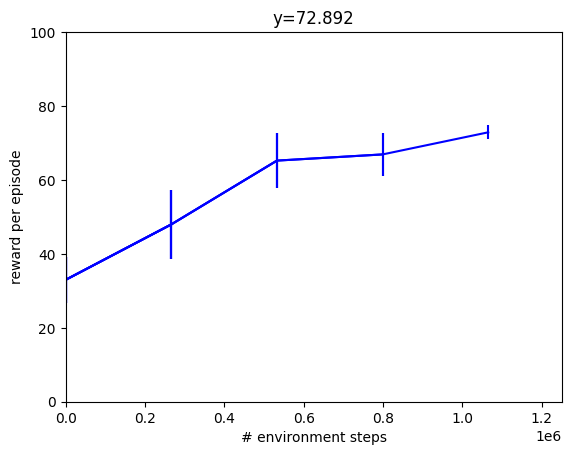

time to jit: 0:00:09.972583
time to train: 0:00:44.563139


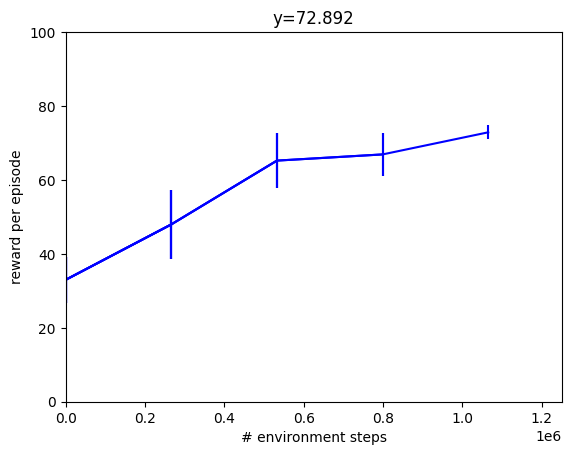

In [11]:
make_inference_fn, params, metrics = train_fn(environment=env)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

#### Visualize the Policy

In [12]:
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

In [ ]:
rng = jax.random.PRNGKey(42)
rollout = []
n_episodes = 1

for _ in range(n_episodes):
  key_rng = jax.random.split(rng, num_envs)
  state = jit_reset(key_rng)
  rollout.append(unvmap(state))
  for i in range(episode_length):
    act_rng, rng = jax.random.split(rng)
    act_rng = jax.random.split(act_rng, num_envs)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(unvmap(state))

render_every = 1
frames = env.render(rollout[::render_every], camera="fixed")
rewards = [s.reward for s in rollout]
media.show_video(frames, fps=1.0 / env.dt / render_every)

plt.plot(np.convolve(rewards, np.ones(10) / 10, mode="valid"))
plt.xlabel("time step")
plt.ylabel("reward")
plt.show()

🙌 See you in Part 2 of pixels-based training with Madrona-MJX, where we'll cover how to use visual domain randomization to transfer policies to the real world!